In [22]:
%%bash
strace -tt -T -r -yy -e read,write -o  logs/mmarrays2.st python src/mmarrays.py 100000

Data size = 819.200 MB
Chunk size = 0.800 MB


In [23]:
!cat logs/mmarrays2.st

15:01:25.383488 (+     0.000000) read(3</lib/x86_64-linux-gnu/libpthread-2.31.so>, "\177ELF\2\1\1\0\0\0\0\0\0\0\0\0\3\0>\0\1\0\0\0 l\0\0\0\0\0\0"..., 832) = 832 <0.000087>
15:01:25.384618 (+     0.001087) read(3</lib/x86_64-linux-gnu/libdl-2.31.so>, "\177ELF\2\1\1\0\0\0\0\0\0\0\0\0\3\0>\0\1\0\0\0000\21\0\0\0\0\0\0"..., 832) = 832 <0.000113>
15:01:25.385439 (+     0.000814) read(3</lib/x86_64-linux-gnu/libutil-2.31.so>, "\177ELF\2\1\1\0\0\0\0\0\0\0\0\0\3\0>\0\1\0\0\0\20\22\0\0\0\0\0\0"..., 832) = 832 <0.000136>
15:01:25.387019 (+     0.001597) read(3</lib/x86_64-linux-gnu/libm-2.31.so>, "\177ELF\2\1\1\3\0\0\0\0\0\0\0\0\3\0>\0\1\0\0\0\0\322\0\0\0\0\0\0"..., 832) = 832 <0.000118>
15:01:25.389308 (+     0.002296) read(3</lib/x86_64-linux-gnu/libc-2.31.so>, "\177ELF\2\1\1\3\0\0\0\0\0\0\0\0\3\0>\0\1\0\0\0@>\2\0\0\0\0\0"..., 832) = 832 <0.000118>
15:01:25.391554 (+     0.002251) read(3</lib/x86_64-linux-gnu/librt-2.31.so>, "\177ELF\2\1\1\0\0\0\0\0\0\0\0\0\3\0>\0\1\0\0\0\260#\0\0\0\0\0\0"..., 

In [41]:
import re

In [47]:
inp_str = 'read(blah,s(),dd)'
pattern = r'read\((.*?)\)[^)]*$'
match = re.search(pattern, inp_str)
match.group(1)

'blah,s(),dd'

In [44]:
from strace_miner.core.strace_analyzer import StraceAnalyzer
from strace_miner.views.v1.io_preprocessor import IOPreprocessor

In [128]:
%%writefile ../strace_miner/core/strace_line_reader.py
import re


class StraceLineReader:
    def __init__(self):
        self.line = ""

    def set_line(self,line):
        self.line = line

    def match_pattern(self,pattern):
        match = re.search(pattern, self.line)
        return match.group(1)

    def parse_attrs(self):
        attrs = self.line.strip().split()
        time = attrs[0]
        dur = attrs[-1][1:-1]
        try:
            dur=float(dur)
        except ValueError:
            dur=0.0
        call = attrs[3].split('(')[0]
        
        ret = [call,time,dur]
            #print(ret)
        return ret

    def parse_call_attrs(self,call):
        pass        

Writing ../strace_miner/core/strace_line_reader.py


In [129]:
%%writefile ../strace_miner/views/v2/io_line_reader.py

from ...core.strace_line_reader import StraceLineReader

class IOLineReaderV2(StraceLineReader):
    def __init__(self):
        super().__init__()
       

    def parse_call_attrs(self,call):
        bytes = 0
        if call == 'read':
            pattern = r'read\((.*?)\)[^)]*$'
            ret = self.match_pattern(pattern).split(',')
            bytes = int(ret[-1])
        elif call == 'write':
            pattern = r'write\((.*?)\)[^)]*$'
            ret = self.match_pattern(pattern).split(',')
            bytes = int(ret[-1])

        if bytes == 0:
            val = '0'
        elif bytes < 1024*4:
            val = '[<4KB]'
        elif bytes < 1024*1024*4:
            val = '[<4MB]'
        else:
            val = '[>4MB]'
        return [val,]

            

Writing ../strace_miner/views/v2/io_line_reader.py


In [130]:
%%writefile ../strace_miner/views/v2/io_miner_v2.py
from ...core.strace_analyzer import StraceAnalyzer
from ...views.v1.io_preprocessor import IOPreprocessor
from .io_line_reader import IOLineReaderV2

import os
import pm4py
import pandas as pd


class IOMinerV2(StraceAnalyzer):
    def __init__(self,st_log_paths,io_calls):
        super().__init__(st_log_paths)
        self.io_calls = io_calls
        self.line_reader = IOLineReaderV2()
    
    def process_line(self, line):
        self.line_reader.set_line(line)
        attrs = self.line_reader.parse_attrs()
        call_attrs = self.line_reader.parse_call_attrs(attrs[0])
        return attrs+call_attrs
    
    def preprocess(self, reuse=False):
        for st_path in self.st_log_paths: 
              st = IOPreprocessor(st_path,self.io_calls)
              st.extra = ['bytes',]
              case_id = os.path.basename(st_path).split('.st')[0]
              if not reuse:
                st.prepare_csv_log(self.process_line)
            
              self.st_logs[case_id] = st
    
    def prepare_summaries_and_event_log(self):
         df_all = []
         for case_id,st in self.st_logs.items():
              df = st.get_df_from_csv()
              summary, df = st.process(df)
              self.summaries[case_id] = summary
              df['case'] = case_id
              df['concept'] = df['call'] + '_' + df['bytes'].astype(str)
              df = pm4py.format_dataframe(df,case_id='case',activity_key='concept',timestamp_key='time')
              df_all.append(df)

         self.el = pm4py.convert_to_event_log(pd.concat(df_all,ignore_index=True))


    def prepare_dfg(self):
         self.dfg,self.dfg_im,self.dfg_fm = pm4py.discover_dfg(self.el)

    def view_dfg(self):
         if self.dfg:
              return pm4py.view_dfg(self.dfg,self.dfg_im,self.dfg_fm)


Writing ../strace_miner/views/v2/io_miner_v2.py


In [122]:
%%bash
strace -tt -T -r -yy -e read,write -o  logs/mmarrays2.st python src/mmarrays.py 100000

Data size = 819.200 MB
Chunk size = 0.800 MB


In [123]:
io_calls = ['read','write','mmap','openat']
sta = IOMinerV2(["logs/mmarrays.st",],io_calls)

In [124]:
sta.preprocess()

CSV log path: logs/mmarrays.csv


In [125]:
sta.st_logs[list(sta.st_logs.keys())[0]].get_df_from_csv()

,call,time,duration,bytes
0,execve,14:58:53.626096,0.000193,0
1,brk,14:58:53.626518,0.000057,0
2,readlink,14:58:53.626701,0.000120,0
3,access,14:58:53.626983,0.000085,0
4,openat,14:58:53.627246,0.000165,0
...,...,...,...,...
12779,munmap,14:58:57.246816,0.000048,0
12780,munmap,14:58:57.246935,0.000034,0
12781,munmap,14:58:57.247015,0.000036,0
12782,exit_group,14:58:57.247283,0.000000,0


In [126]:
sta.prepare_summaries_and_event_log()
sta.prepare_dfg()

/home/vscode/.local/lib/python3.12/site-packages/pm4py/utils.py:538: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


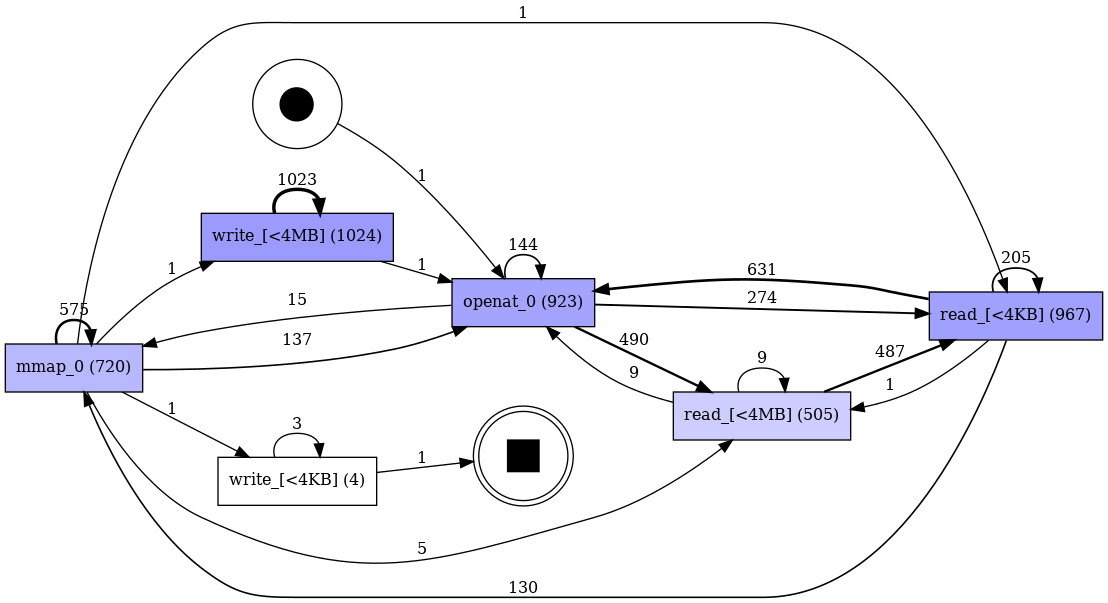

In [127]:
sta.view_dfg()